In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.utils.np_utils import to_categorical

# Task 1: Acquire the Data

In [ ]:
#load the data, vectorize it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

unormalized_x_train = x_train
unormalized_x_test = x_test
# added by marwan

# normalization to [0,1] range
x_train = x_train / 255
x_test = x_test /255

## reshape the inputs
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)

#reshaping unormalized images
unormalized_x_train = unormalized_x_train.reshape(unormalized_x_train.shape[0],-1)
unormalized_x_test = unormalized_x_test.reshape(unormalized_x_test.shape[0],-1)
y_train_uncat=y_train
y_train = to_categorical(y_train)


4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

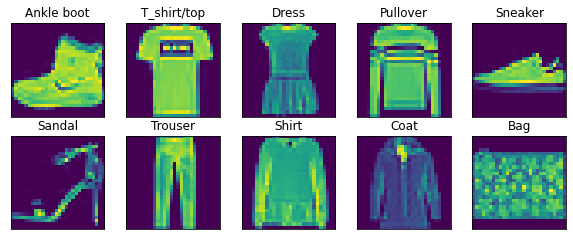

In [ ]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 10))
list_ = []
y = 0
for i in [0,1,3,5,6,8,16,18,19,23]:
    label_index = int(y_train_uncat[i])
    if class_names[label_index] not in list_:
      plt.subplot(5, 5, y + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x_train[i].reshape((28,28)))
      plt.title(class_names[label_index])
      list_.append(class_names[label_index])
      y += 1
plt.show()

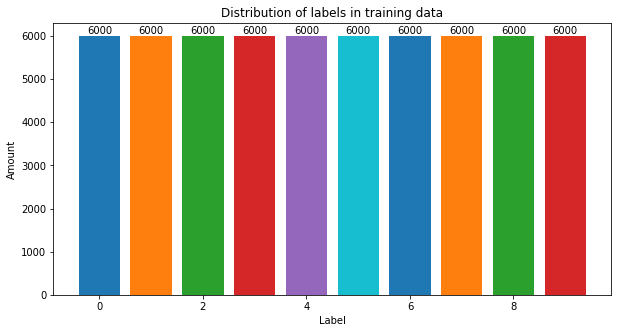

In [ ]:
#Distribution of training data class
targets, frequency = np.unique(y_train_uncat, return_counts=True)

fig=plt.figure(figsize=(10, 5))
plt.bar(targets,frequency,color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:cyan'])
plt.title('Distribution of labels in training data')
plt.xlabel('Label')
plt.ylabel('Amount')

for a,b in zip(targets, frequency):
    plt.text(a, b, '%d' % b, ha='center', va='bottom',fontsize=10)

plt.show()

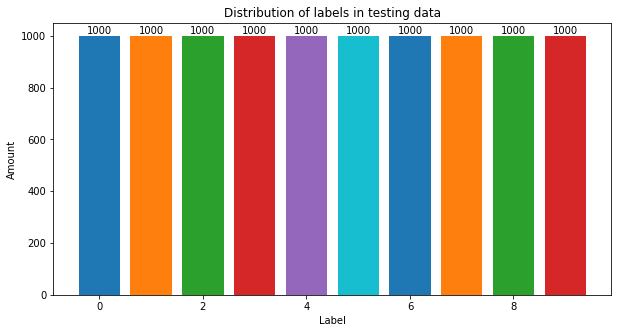

In [ ]:
#Distribution of training data class
targets, frequency = np.unique(y_test, return_counts=True)

fig=plt.figure(figsize=(10, 5))
plt.bar(targets,frequency,color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:cyan'])
plt.title('Distribution of labels in testing data')
plt.xlabel('Label')
plt.ylabel('Amount')

for a,b in zip(targets, frequency):
    plt.text(a, b, '%d' % b, ha='center', va='bottom',fontsize=10)
    
plt.show()

# Tast 2: Implement a Multilayer Perceptron

In [ ]:
class Cost_Cross_Entropy:
    def __init__(self, activation_fn):
        self.activation_fn = activation_fn
        self.gamma=None

    def transform(self, x, gamma=0.01):
      self.gamma=gamma
      return self.activation_fn.transform(x,gamma=gamma)

    def loss(y_true, y_pred):
        epsilon=1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        N = y_pred.shape[0]
        loss = -np.sum(y_true*np.log(y_pred+1e-9))/N
        return loss

    @staticmethod
    def derivative(Y, AL):  
        return AL - Y

    def delta(self, y_true, y_pred):
        return self.derivative(y_true, y_pred) * self.activation_fn.derivative(y_pred, self.gamma)

In [ ]:
import numpy as np

class Relu:
    def transform(x,gamma=0.01):
      return np.maximum(0,x)
    def derivative(d, gamma=0.01):
        mask = d <= 0
        out=d.copy()
        out[mask] = 0
        out[d>0] = 1
        return out

class Leaky_Relu:
    def transform(x, gamma=0.01):
      # print(f'gamma is {gamma}')
      return np.maximum(0,x) + gamma*np.minimum(0,x)

    def derivative(d, gamma=0.01):
        # print(f'inside d, gamma is {gamma}')
        mask = d <= 0
        out=d.copy()
        out[mask] = gamma
        out[d>0] = 1
        return out

class Sigmoid:
    def transform(x,gamma=0.01):
        return 1 / (1 + np.exp(-x))
    def derivative(d, gamma=0.01):
        d_transformed = 1 / (1 + np.exp(-d))
        return d_transformed * (1 - d_transformed)

class Tanh:
    def transform(x,gamma=0.01):
      return np.tanh(x)
      
    def derivative(d, gamma=0.01):
      transformed = Tanh.transform(d,gamma=0.01)
      return 1 - transformed**2


class Softmax:
    def transform(x,gamma=0.01):
      exp_ = x-np.max(x)
      nx = np.exp(exp_)
      sum = np.sum(nx, axis=1, keepdims=True)
      return nx/sum

    def derivative(d,gamma=0.01):
        return Softmax.transform(d,gamma=0.01)*Softmax.transform(1-d,gamma=0.01)

In [ ]:
class MLP:

    def __init__(self, input_layer=784, hidden_layer=[], output_layer=10, epochs=20, active_func=[], batch_size=200, learning_rate=0.1, gamma=0.01, keep_dropout_ratio = 1):
        self.gamma=gamma
        self.lambda_=0
        self.epochs=epochs
        self.batch_size=batch_size
        self.learning_rate=learning_rate
        
        self.dimensions=[input_layer]
        for h in hidden_layer:
          self.dimensions.append(h)
        self.dimensions.append(output_layer)

        self.num_layers = len(self.dimensions)
        self.weights = {}
        self.bias = {}
        self.active_func = {}
        rng=len(self.dimensions) - 1

        for i in range(rng):
            self.weights[i + 1] = np.random.randn(self.dimensions[i], self.dimensions[i + 1])
            dim_sqrt = np.sqrt(self.dimensions[i])
            self.weights[i + 1]= self.weights[i + 1]/dim_sqrt

      

        for i in range(rng):
            self.bias[i + 1] = np.zeros(self.dimensions[i + 1])

        count=0
        rng=len(active_func)
        if (rng==0):
          self.active_func[2]=Softmax
        else:
          for i in range(rng):
              count=i+2
              self.active_func[i + 2] = active_func[i]
          self.active_func[count+1]=Softmax
        self.loss = Cost_Cross_Entropy(self.active_func[self.num_layers])


    def propagate(self, x):
        y_x = {}
        y_c = {1: x}  
        for idx in range(1, self.num_layers):
            next_idx=idx+1
            y_x[next_idx] = self.bias[idx]+ np.dot(y_c[idx], self.weights[idx])
            y_c[next_idx] = self.active_func[next_idx].transform(y_x[next_idx],self.gamma)
        return y_x, y_c  

    def back_propagate(self, z, a, y_true):
        delta = self.loss.delta(y_true, a[self.num_layers])
        dw = np.dot(a[self.num_layers - 1].T, delta)

        params = {
            self.num_layers - 1: (dw, delta)
        }

        for i in reversed(range(2, self.num_layers)):
            delta = np.dot(delta, self.weights[i].T) * self.active_func[i].derivative(z[i], self.gamma)
            dw = np.dot(a[i - 1].T, delta)
            params[i - 1] = (dw, delta)
	
        for key, val in params.items():
            dw=val[0]
            index=key
            dw += (self.lambda_) * self.weights[index] 
            self.weights[index] -= self.learning_rate * dw
            self.bias[index] -= self.learning_rate * np.mean(val[1], 0)
    
    def fit(self, X_train, y_train):

        for i in range(self.epochs):
            seed = np.arange(X_train.shape[0])
            np.random.shuffle(seed)
            x_ = X_train[seed]
            y_ = y_train[seed]
            iter = X_train.shape[0] // self.batch_size

            for i2 in range(iter):
                k = i2 * self.batch_size
                l = (i2 + 1) * self.batch_size
                y_x, y_c = self.propagate(x_[k:l])
                self.back_propagate(y_x, y_c, y_[k:l])

            if (i + 1) % 10 == 0:
               _, a = self.propagate(X_train)
               y_pred = a[self.num_layers]
              
    def predict(self, x):
        y_x, y_c = self.propagate(x)
        return np.argmax(y_c[self.num_layers],axis=1)

    @staticmethod   
    def evaluate (true_,predicted):
        predicted_shape=predicted.shape[0]
        return np.sum(true_ == predicted)/predicted_shape


# Task 3: Run the experiments and report
## please run the code to assure the graphs and results are updated

In [ ]:
### function for graphing
def graphing(hidden,activ,gamma_val=0.01,keep_dropout_val=1,batch_val = 200,learning_val=0.1):
  epoch_options = [0,1,2,3,4,8,10,14,20]
  training_accuracies = []
  testing_accuracies = []
  for epoch in epoch_options:
    model = MLP(hidden_layer=hidden, active_func=activ,gamma=gamma_val,keep_dropout_ratio=keep_dropout_val,epochs=epoch,
                batch_size=batch_val, learning_rate=learning_val)
    model.fit(x_train,y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    training_accuracy = model.evaluate(y_train_uncat, y_predict_train)
    testing_accuracy = model.evaluate(y_test, y_predict_test)
    print("testing accuracy at " + str(epoch) + ': '+ str(testing_accuracy))
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)
  plt.plot(epoch_options,training_accuracies,label='training accuracies')
  plt.plot(epoch_options,testing_accuracies,label='testing accuracies')
  plt.xlabel('epochs')
  plt.ylabel('accuracies')
  plt.legend()
  plt.show()

(please note that results to question 1 can be found under bonus a)

Question 2

testing accuracy at 0: 0.1036
testing accuracy at 1: 0.8256
testing accuracy at 2: 0.836
testing accuracy at 3: 0.8433
testing accuracy at 4: 0.8425
testing accuracy at 8: 0.8597
testing accuracy at 10: 0.8724
testing accuracy at 14: 0.8653
testing accuracy at 20: 0.8839


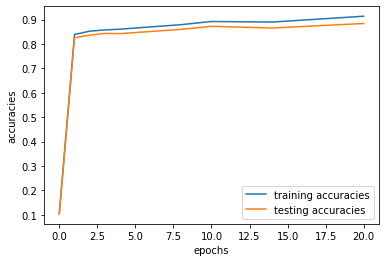

In [ ]:
graphing(hidden=[128,128],activ=[Tanh,Tanh])

testing accuracy at 0: 0.0984
testing accuracy at 1: 0.818
testing accuracy at 2: 0.8421
testing accuracy at 3: 0.8513
testing accuracy at 4: 0.846
testing accuracy at 8: 0.8699
testing accuracy at 10: 0.8626
testing accuracy at 14: 0.8515
testing accuracy at 20: 0.864


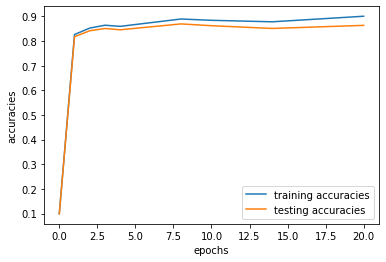

In [ ]:
graphing(hidden=[128,128],activ=[Leaky_Relu,Leaky_Relu])

Question 2 Extra

testing accuracy at 0: 0.1056
testing accuracy at 1: 0.8118
testing accuracy at 2: 0.8371
testing accuracy at 3: 0.8469
testing accuracy at 4: 0.8499
testing accuracy at 8: 0.8656
testing accuracy at 10: 0.8705
testing accuracy at 14: 0.8702
testing accuracy at 20: 0.8778


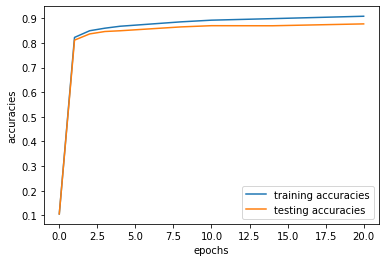

testing accuracy at 0: 0.0713
testing accuracy at 1: 0.8199
testing accuracy at 2: 0.8266
testing accuracy at 3: 0.8442
testing accuracy at 4: 0.8442
testing accuracy at 8: 0.8646
testing accuracy at 10: 0.8655
testing accuracy at 14: 0.8748
testing accuracy at 20: 0.8808


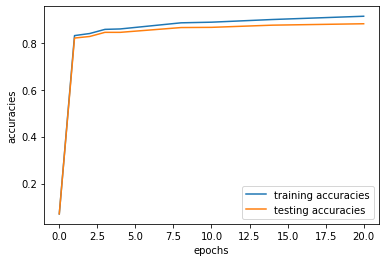

testing accuracy at 0: 0.1152
testing accuracy at 1: 0.7924
testing accuracy at 2: 0.8356
testing accuracy at 3: 0.8399
testing accuracy at 4: 0.8505
testing accuracy at 8: 0.8576
testing accuracy at 10: 0.8555
testing accuracy at 14: 0.8651
testing accuracy at 20: 0.8774


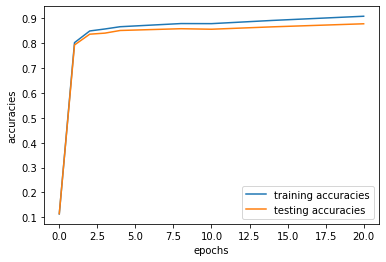

testing accuracy at 0: 0.1673
testing accuracy at 1: 0.8068
testing accuracy at 2: 0.8157
testing accuracy at 3: 0.8348
testing accuracy at 4: 0.8409
testing accuracy at 8: 0.8584
testing accuracy at 10: 0.8625
testing accuracy at 14: 0.8466
testing accuracy at 20: 0.8597


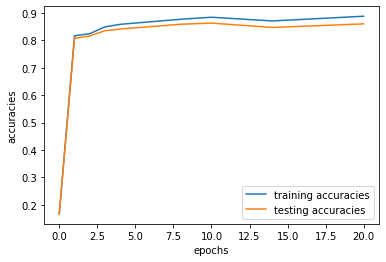

testing accuracy at 0: 0.1487
testing accuracy at 1: 0.7966
testing accuracy at 2: 0.8123
testing accuracy at 3: 0.8336
testing accuracy at 4: 0.8273
testing accuracy at 8: 0.8528
testing accuracy at 10: 0.8174
testing accuracy at 14: 0.8443
testing accuracy at 20: 0.8584


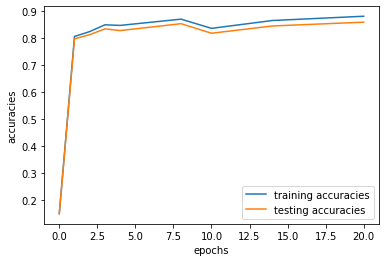

testing accuracy at 0: 0.066
testing accuracy at 1: 0.7988
testing accuracy at 2: 0.7982
testing accuracy at 3: 0.8178
testing accuracy at 4: 0.8064
testing accuracy at 8: 0.8006
testing accuracy at 10: 0.8261
testing accuracy at 14: 0.8369
testing accuracy at 20: 0.8272


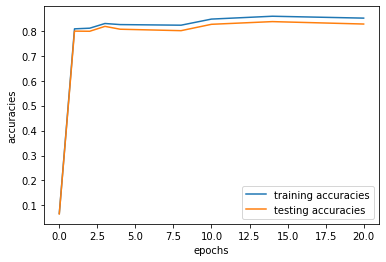

In [ ]:
gamma_values=[0.001, 0.01, 0.1, 0.25, 0.5, 1.0]
for gm in gamma_values:
  graphing(hidden=[128],activ=[Leaky_Relu],gamma_val=gm)

Question 3

testing accuracy at 0: 0.0781
testing accuracy at 1: 0.8163


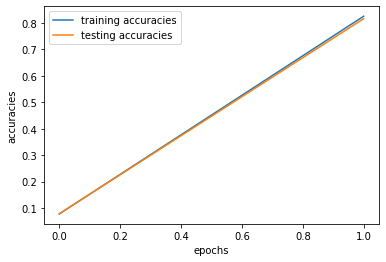

testing accuracy at 0: 0.1633
testing accuracy at 1: 0.7788


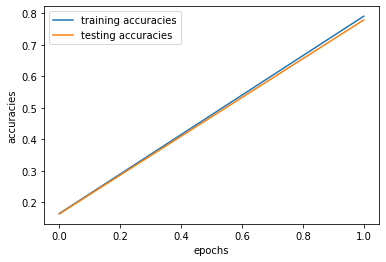

testing accuracy at 0: 0.1405
testing accuracy at 1: 0.803


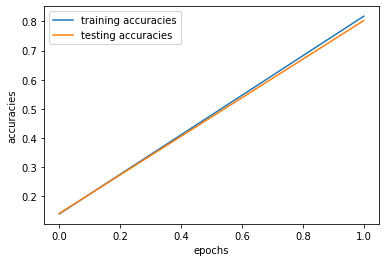

testing accuracy at 0: 0.1038
testing accuracy at 1: 0.8251


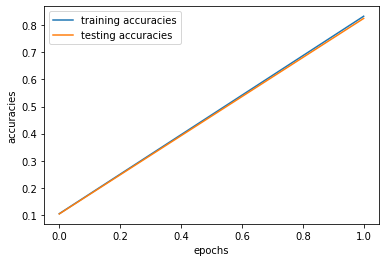

testing accuracy at 0: 0.0499
testing accuracy at 1: 0.8184


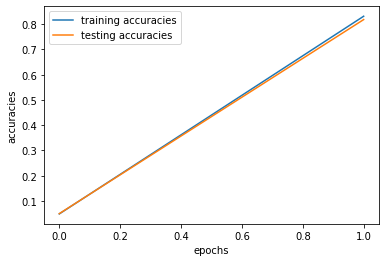

testing accuracy at 0: 0.0846
testing accuracy at 1: 0.8174


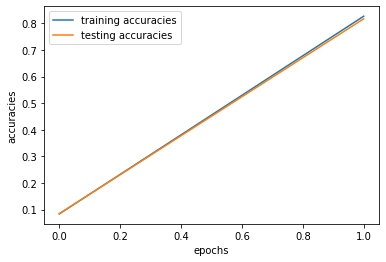

testing accuracy at 0: 0.1449
testing accuracy at 1: 0.8064


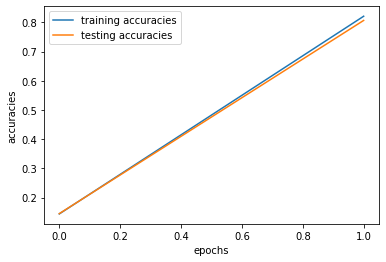

testing accuracy at 0: 0.1139
testing accuracy at 1: 0.7959


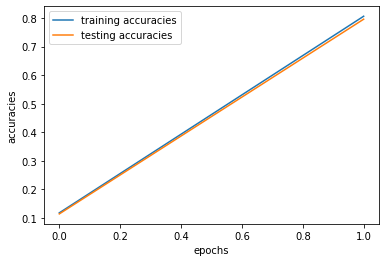

testing accuracy at 0: 0.1063
testing accuracy at 1: 0.7867


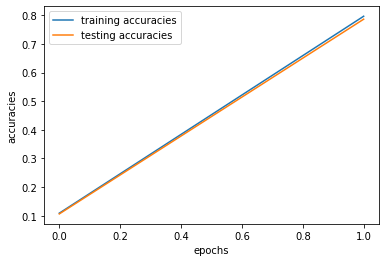

testing accuracy at 0: 0.1093
testing accuracy at 1: 0.7956


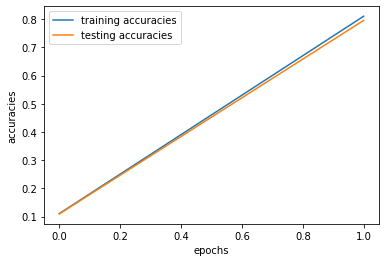

testing accuracy at 0: 0.1029
testing accuracy at 1: 0.7765


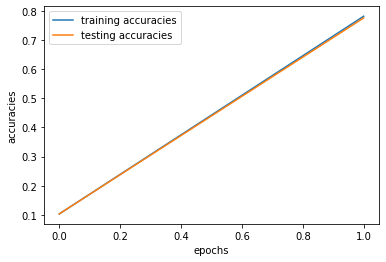

In [ ]:
# do multiple layers, and add 1
keep_ratios = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for keep_ratio in keep_ratios:
  graphing(hidden=[128,128], activ=[Relu, Relu], keep_dropout_val=keep_ratio)

Question 4

In [ ]:
model =  MLP(hidden_layer=[128,128], active_func=[Relu, Relu], epochs=200)
model.fit(unormalized_x_train,y_train)
y_predict = model.predict(unormalized_x_test )
print(  "accuracy: " + str(model.evaluate(y_test, y_predict))  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


Bonus a : Look at different amount of nodes (includes Q1)

testing accuracy at 0: 0.1711
testing accuracy at 1: 0.7763


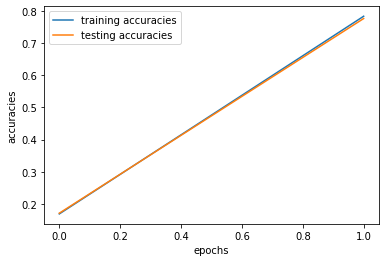

testing accuracy at 0: 0.0941
testing accuracy at 1: 0.8002


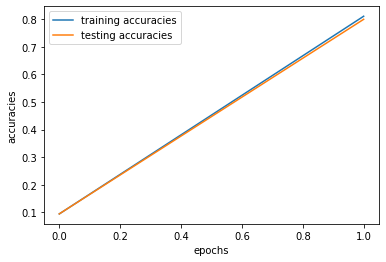

testing accuracy at 0: 0.0769
testing accuracy at 1: 0.81


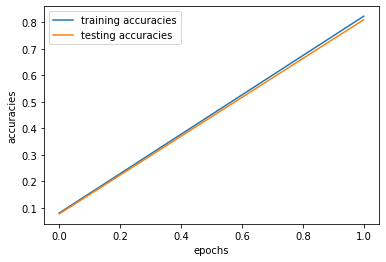

testing accuracy at 0: 0.1359
testing accuracy at 1: 0.8098


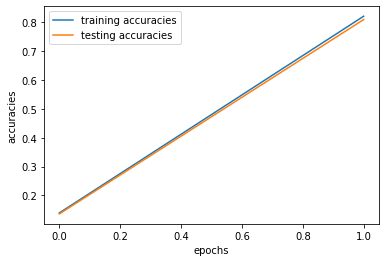

testing accuracy at 0: 0.1075
testing accuracy at 1: 0.8105


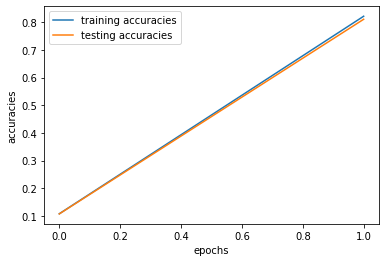

testing accuracy at 0: 0.0702
testing accuracy at 1: 0.8157


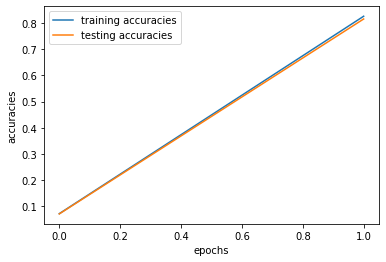

testing accuracy at 0: 0.109
testing accuracy at 1: 0.8184


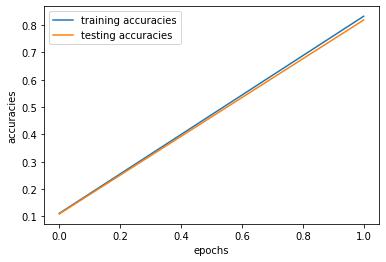

In [ ]:
hidden_layer_options = [[],[64],[64,64],[128],[128,128],[256],[256,256]]
for hidden_layer_amount in hidden_layer_options:
  activ=[]
  for j in range(len(hidden_layer_amount)):
    activ.append(Relu)
  graphing(hidden=hidden_layer_amount,activ=activ)

Bonus b: Look at different batch size and learning rates

testing accuracy at 0: 0.0731
testing accuracy at 1: 0.8205


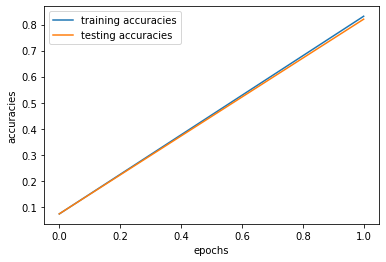

testing accuracy at 0: 0.0675
testing accuracy at 1: 0.8017


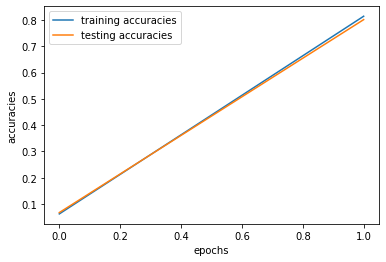

testing accuracy at 0: 0.1372
testing accuracy at 1: 0.7783


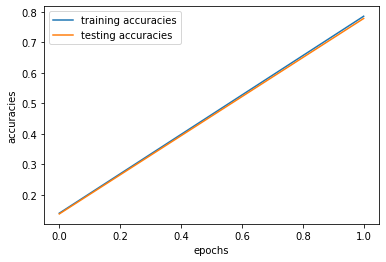

In [ ]:
batch_sizes = [100,200,400]
for size in batch_sizes:
  graphing(hidden=[128,128],activ=[Relu, Relu], batch_val=size)

testing accuracy at 0: 0.0719
testing accuracy at 1: 0.7959


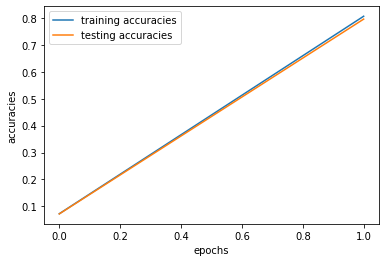

testing accuracy at 0: 0.1016
testing accuracy at 1: 0.8192


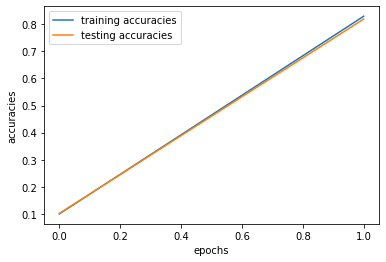

testing accuracy at 0: 0.0707
testing accuracy at 1: 0.7879


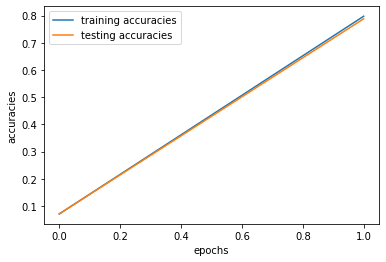

testing accuracy at 0: 0.074
testing accuracy at 1: 0.7162


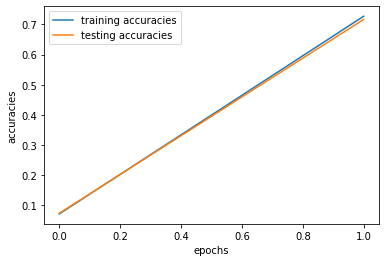

testing accuracy at 0: 0.1157
testing accuracy at 1: 0.6826


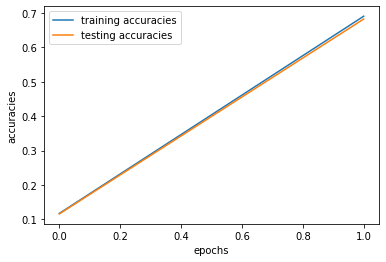

testing accuracy at 0: 0.1038
testing accuracy at 1: 0.3677


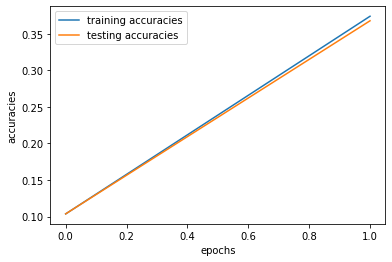

In [ ]:
rates = [0.2, 0.1, 0.05, 0.01, 0.005, 0.001]
for rate in rates:
  graphing(hidden=[128,128],activ=[Relu, Relu], learning_val=rate)

In [ ]:
#try sigmoid
model_2_hidden_tanh = MLP(hidden_layer=[128,128], active_func=[Sigmoid,Sigmoid])
model_2_hidden_leaky_relu = MLP(hidden_layer=[128,128], active_func=[Leaky_Relu,Leaky_Relu])
for model in [model_2_hidden_tanh,model_2_hidden_leaky_relu]:
  model.fit(x_train,y_train)
  y_predict = model.predict(x_test)
  print(  "accuracy: " + str(model.evaluate(y_test, y_predict))  )
  '''
accuracy: 0.8478
accuracy: 0.8723
  '''

In [ ]:
#epoch
epochs_options = [10, 25, 50, 100, 150, 200, 250, 300,350]

for epochs_amount in epochs_options:
  model = MLP(hidden_layer=[128,128], active_func=[Relu,Relu], learning_rate=rate,epochs = epochs_amount)
  model.fit(x_train,y_train)
  y_predict = model.predict(x_test)
  print(epochs_amount)
  print(  "accuracy: " + str(model.evaluate(y_test, y_predict))  )
  '''
10
accuracy: 0.7102
25
accuracy: 0.7933
50
accuracy: 0.8199
100
accuracy: 0.8376
150
accuracy: 0.8509
200
accuracy: 0.8586
250
accuracy: 0.8612
300
accuracy: 0.8637
350
accuracy: 0.8636
  '''

Bonus c: Large parameter search

In [ ]:
hidden_layer_options = [[],[128],[128,128],[256],[256,256]]
epochs_options = [100,200,300]
active_func_options = [Relu,Leaky_Relu,Sigmoid,Tanh]
batch_size_options=[100, 200,400]
learning_rate_options=[0.2, 0.1, 0.05, 0.01, 0.005, 0.001]
keep_dropout_ratio_options = [0.25,0.5, 0.75,1]

highest_accuracy = 0
optimal_layers = None
optimal_iterations = None
optimal_funct = None
optimal_batch_size = None
optimal_learning_rate = None
optimal_keep = None

for hidden_layer_amount in hidden_layer_options:
  for epochs_amount in epochs_options:
    for active_func_amount in active_func_options:
      for batch_size_amount in batch_size_options:
        for learning_rate_amount in learning_rate_options:
          # build activation layers
          activ=[]
          for j in range(len(hidden_layer_amount)):
            activ.append(active_func_amount)
          print(activ)

          for keep_dropout_ratio_amount in keep_dropout_ratio_options:
            model = MLP(hidden_layer=hidden_layer_amount,epochs = epochs_amount,
                        active_func=activ,batch_size=batch_size_amount,
                        learning_rate=learning_rate_amount,keep_dropout_ratio=keep_dropout_ratio_amount,gamma=0.001)
            model.fit(x_train,y_train)
            y_predict = model.predict(x_test)
            accuracy = model.evaluate(y_test, y_predict)
            print(f'hidden layer: {hidden_layer_amount} epochs: {epochs_amount} batch_size: {batch_size_amount} learning rate: {learning_rate_amount}  accuracy: {accuracy} active_func: {activ} ' )
            if accuracy > highest_accuracy:
              highest_accuracy = accuracy
              optimal_layers = hidden_layer_amount
              optimal_iterations = epochs_amount
              optimal_funct = active_func_amount
              optimal_batch_size = batch_size_amount
              optimal_learning_rate = learning_rate_amount
              optimal_keep = keep_dropout_ratio_amount
print("Highest accuracy: " + str(highest_accuracy))
print("layers: " + str(optimal_layers))
print("iterations: "+str(optimal_iterations))
print("function: "+str(optimal_funct))
print("batch_size: "+str(optimal_batch_size))
print("learning_rate: "+str(optimal_learning_rate))
print("keep_ratio: "+str(optimal_keep))